# Midterm 1 on the Ising model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import matplotlib.patches as mpatches

import tqdm.notebook # Progress bar for loops
import numba as nb

# Import user written module
import one_d_ising as ising

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plot settings
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

Define parameter values

In [2]:
N = 1000
x_axis = range(N) # This is used to plot the lattice configuration

# Iteration parameters
n_max = 10000
n_0 = 8000

Run metropolis hastings and plot the resulting configuration and time series of magnetization

In [263]:
# Initialize
config = ising.initialstate(N)
energy_vec = np.empty(n_max)
mag_vec = np.empty(n_max)
beta = 100

# Perform n_max Monte Carlo steps
for i in range(n_max) :

    # Energy per site and average magnetization
    energy_vec[i] = ising.calcEnergy(config)
    mag_vec[i] = ising.calcMag(config)
    
    # Perform MC move
    ising.montecarlo(config, beta)

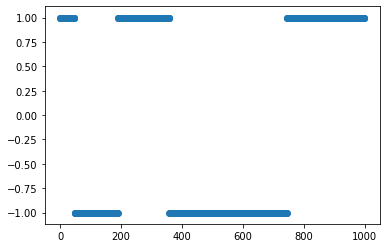

In [264]:
plt.scatter(x_axis,config)

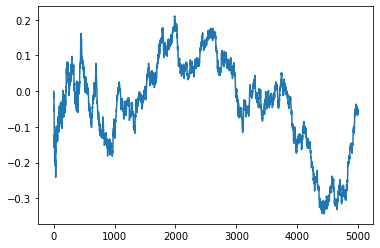

In [266]:
plt.plot(mag_vec)

Run the same procedure for the random neighbour model

In [267]:
# Initialize
config2 = ising.initialstate(N)
energy_vec = np.empty(n_max)
mag_vec = np.empty(n_max)
beta = 1/2 # Find some reasonable value

# Perform n_max Monte Carlo steps
for i in range(n_max) :

    # Energy per site and average magnetization
    energy_vec[i] = ising.calcEnergy(config)
    mag_vec[i] = ising.calcMag(config)
    
    # Perform MC move
    ising.montecarlo_random(config, beta)

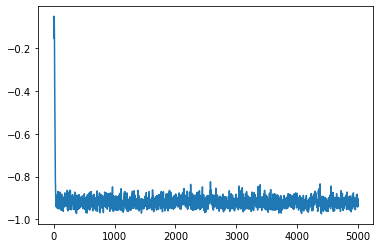

In [268]:
plt.plot(mag_vec)

## Magnetization as a function of temperature

In [39]:
################
## Initialize ##
################

kbT_vec = np.linspace(0.5, 3.5, 50) # Vector of values of inverse beta
energy_vec_kbT = np.empty((2, len(kbT_vec)))
mag_vec_kbT = np.empty((2, len(kbT_vec)))
repetitions = 1 # Can increase the number 
config = np.empty((2,N))

#####################
## Run Monte Carlo ##
#####################

# Standard model
for i,kbT in enumerate(kbT_vec):

    # Initialize    
    config[0] = ising.initialstate(N) # Standard WRITE THIS BETTER SOON!
    mag_temp = np.zeros(n_max - (n_0 + 1)) + np.nan
    
    # Beta is the inverse temperature
    beta_val = 1.0/kbT

    # run MC-MC
    for it in range(n_max):

        # Run Monte Carlo
        ising.montecarlo(config[0], beta_val)

        # Begin to store data after n0 mc steps
        if it > n_0:
            mag_temp[it - n_0 - 1] = ising.calcMag(config[0])

    # Save the resulting energy and magnetization
    mag_vec_kbT[0,i] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric
    

# Random neighbour model
for i,kbT in enumerate(kbT_vec):

    # Initialize
    config[1] = ising.initialstate(N) # Random neighbour
    mag_temp = np.zeros(n_max - (n_0 + 1)) + np.nan
    
    # Beta is the inverse temperature
    beta_val = 1.0/kbT

    # run MC-MC
    for it in range(n_max):

        # Run Monte Carlo
        ising.montecarlo_random(config[1], beta_val)

        # Begin to store data after n0 mc steps
        if it > n_0:
            mag_temp[it - n_0 - 1] = ising.calcMag(config[1])

    # Save the resulting energy and magnetization
    mag_vec_kbT[1,i] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric

NameError: name 'kbT_vec' is not defined

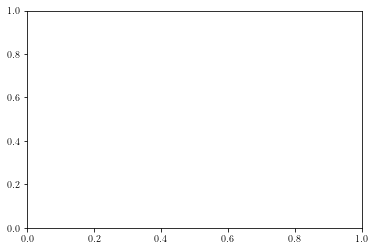

In [40]:
# Initialize figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Standard model
ax.plot(kbT_vec, mag_vec_kbT[0,:], linewidth = 0.5, color = 'blue', linestyle = '-')
ax.scatter(kbT_vec, mag_vec_kbT[0,:], color = 'blue', alpha = 0.5, s = 10, edgecolor='k', linewidth = 0.2, label='Standard')

# Random neighbour model
std1 = ax.plot(kbT_vec, mag_vec_kbT[1,:], linewidth = 0.5, color = 'red', linestyle = '-')
std2 = ax.scatter(kbT_vec, mag_vec_kbT[1,:], color = 'red', s = 10, alpha=0.5, edgecolor = 'k', linewidth= 0.2, label = 'Random Neighbour')

# ax.set_title('Magnetization per Site')
rnd1 = ax.set_xlabel('$k_B T$')
rnd2 = ax.set_ylabel('$\\langle M \\rangle$')

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.set_xlim(0.5,3.5)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../midterm_1/magnetization.pdf')

Something about results. The graphs shows that only the random neighbour model exhibits a phase transition for finite temperatures. Note that the standard model still has a phase transition at $T=0$, but it might not be possible to estimate the temperature as we can only approach this point from above.

## Estimate the critical temperature 

Only focus on the random neighbour model.
Strategy to identify $T_c$:
1. Estimate $|m|$ as a function of temperature for small interval
2. Make rule for $m(T_{i} > \varepsilon$
3. If temperature increase is above the threshold set $T_c := (T_{i} + T_{i-1})/2 $

Lastly, loop this procedure over decreasing values of $1/N$. Use this expression to have in infinite limit of $N$ expresed on finite terms.

From inspecting the above plot, I narrow the temperature analysis to the interval $T \in [2,3]$.

When extrapolating the critical temperature in the thermodynamic limit, plot the values of $T_c$ against $1/N$ and estimat the relationship econometrically. Then compute the fitted value for the thermodynamic limit

In [20]:
N_vals = np.linspace(100, 2000, 20)
temperature = np.linspace(2.0, 3.0, 20) # Vector of values of inverse beta

mag = np.empty((len(N_vals),len(temperature))) + np.nan
np.shape(mag)

(20, 20)

In [127]:
################
## Initialize ##
################

temperature = np.linspace(2.4, 3.8, 20) # Vector of values of inverse beta
temperature_reverse = temperature[::-1]

N_vals = np.linspace(500, 5000, 20)
mag = np.empty((len(N_vals),len(temperature))) + np.nan
T_c = np.empty(len(N_vals)) + np.nan
               
#####################
## Run Monte Carlo ##
#####################
for i,N_i in enumerate(N_vals):
    for j,kbT in enumerate(temperature):
        
        N = np.int(np.rint(N_i))
        
        # Initialize with N_i sites
        state = ising.initialstate(N)
        mag_temp = np.zeros(n_max - (n_0 + 1)) + np.nan
        
        # Beta is the inverse temperature
        beta_val = 1.0/kbT

        # Run MC-MC
        for it in range(n_max):

            # Run Monte Carlo
            ising.montecarlo_random(state, beta_val)

            # Begin to store data after n0 mc steps
            if it > n_0:
                mag_temp[it - n_0 - 1] = np.mean(state)

        # Save the resulting energy and magnetization
        mag[i,j] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric

Identify the critical temperature. Take into account the noise around the critical point. For now, say that a phase transition occurs if $|m|>0.2$.

Estimate the critical temperature

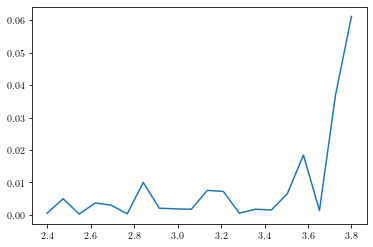

In [137]:
plt.plot(temperature, mag_reverse[4,:])

In [106]:
mag_reverse[5,8]

0.019361818676559187

In [129]:
temperature_reverse

array([3.8       , 3.72631579, 3.65263158, 3.57894737, 3.50526316,
       3.43157895, 3.35789474, 3.28421053, 3.21052632, 3.13684211,
       3.06315789, 2.98947368, 2.91578947, 2.84210526, 2.76842105,
       2.69473684, 2.62105263, 2.54736842, 2.47368421, 2.4       ])

In [138]:
# Compute the critical temperature
mag_reverse = np.flip(mag, axis=1)
T_c = np.empty(len(N_vals)) + np.nan

for i in range(len(N_vals)):
    for j in range(len(temperature)):
        
#         print(mag_reverse[i,j])
        
        # Stop when magnetization is positive, for a given N
        if mag_reverse[i,j] > 0.01:
#             print('true')
            T_c[i] = (temperature_reverse[j] + temperature_reverse[j-1])/2

            break

In [139]:
T_c

array([3.39473684, 3.46842105, 2.95263158, 2.95263158, 2.65789474,
       2.51052632, 3.02631579, 2.58421053, 2.65789474, 2.51052632,
       2.87894737, 2.65789474, 2.73157895, 2.58421053, 2.58421053,
       2.51052632, 2.80526316, 2.51052632, 2.51052632, 2.51052632])

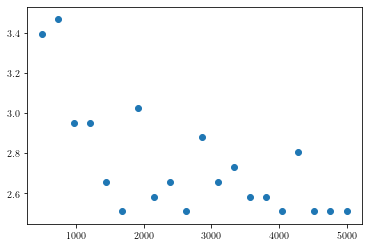

In [143]:
plt.scatter(N_vals, T_c)

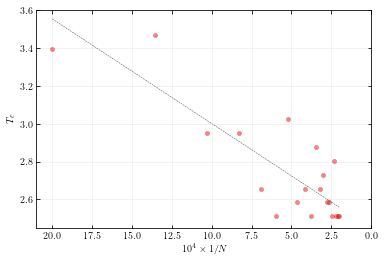

In [211]:
N_inv = 1/N_vals
amplification = 1e+4

# Initialize figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Random neighbour model
# ax.plot(kbT_vec, mag_vec_kbT[1,:], linewidth = 0.5, color = 'red', linestyle = '-')
ax.scatter(amplification*N_inv, T_c, color = 'red', s = 20, alpha = 0.5, edgecolor = 'k', linewidth= 0.2)
ax.plot(amplification*N_inv, fitted, linewidth = 0.5, color = '0.3', linestyle = '--')

ax.set_xlabel(r'$10^{4} \times 1/N$')
ax.set_ylabel('$T_c$')

ax.set_xlim(21,0)
ax.set_ylim(2.45,3.6)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../midterm_1/T_c.pdf')

Estimate best linear fit

In [213]:
alpha_1 = np.cov(T_c, amplification*N_inv)[1,0] / np.var(amplification*N_inv)
alpha_0 = np.mean(T_c - alpha_1*amplification*N_inv)
fitted = alpha_0 + alpha_1*N_inv * amplification

In [214]:
print(alpha_0)
print(alpha_1)

2.448460191875788
0.05533566949638419


Extrapolated value

In [151]:
T_c_fitted = alpha_0